In [ ]:
import yfinance as yf
import pandas as pd

# Fetch BTC-USD data for the past 5 years
btc = yf.download("BTC-USD", start="2020-01-01", end="2025-02-28")

# Display the first 5 rows
print(btc.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095


[*********************100%***********************]  1 of 1 completed


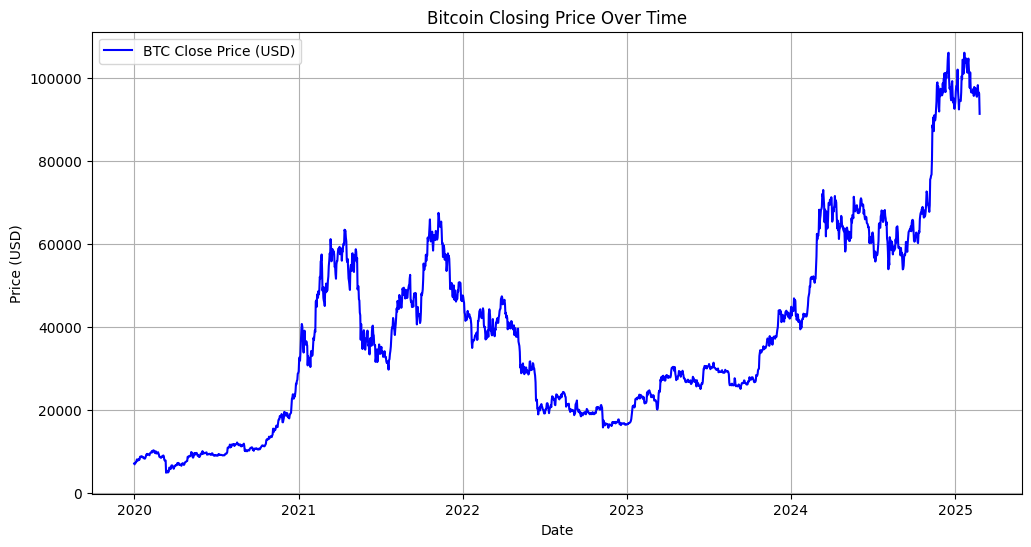

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch BTC-USD data for the past 5 years
btc = yf.download("BTC-USD", start="2020-01-01", end="2025-02-25")

# Plot the closing price trend
plt.figure(figsize=(12, 6))
plt.plot(btc.index, btc["Close"], label="BTC Close Price (USD)", color="blue")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()


In [1]:
import requests

# API endpoint to fetch real-time Bitcoin price
url = "https://api.coingecko.com/api/v3/simple/price"
params = {"ids": "bitcoin", "vs_currencies": "usd"}

# Send GET request to the API and parse the response
response = requests.get(url, params=params).json()

# Print real-time Bitcoin price in USD
print(f"BTC Real-Time Price: ${response['bitcoin']['usd']}")


BTC Real-Time Price: $84981


[*********************100%***********************]  1 of 1 completed

📥 Downloading Bitcoin data (10 years)...
✅ Data ready: Training samples = 3618
🚀 Training the model...



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Loss: 0.295322
Epoch 10, Loss: 0.003609
Epoch 20, Loss: 0.003236
Epoch 30, Loss: 0.002896
Epoch 40, Loss: 0.002649
Epoch 50, Loss: 0.002630
Epoch 60, Loss: 0.002701
Epoch 70, Loss: 0.002226
Epoch 80, Loss: 0.002200
Epoch 90, Loss: 0.002004


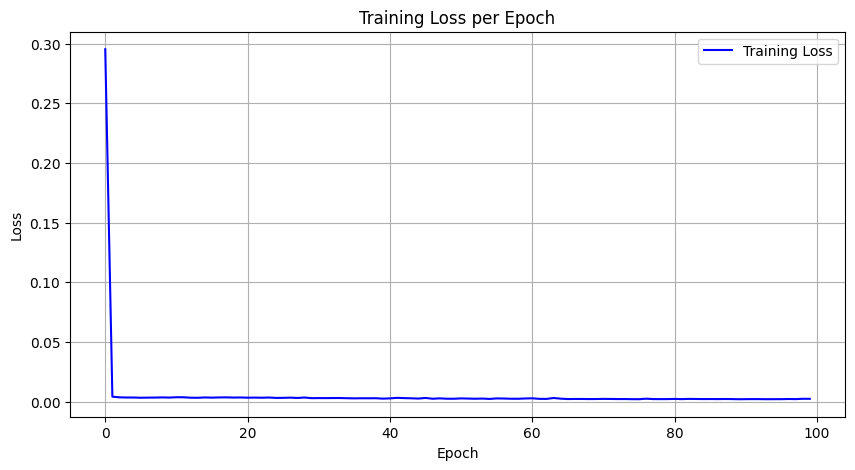

✅ Training complete!
🔮 Predicting future Bitcoin prices...


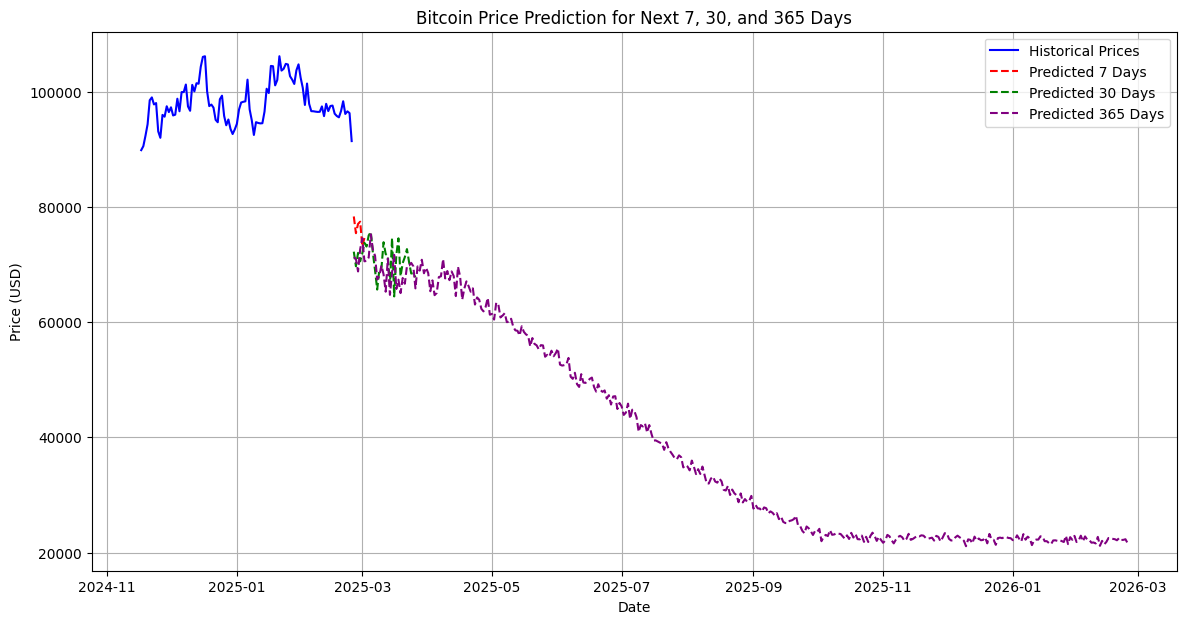

✅ Prediction complete!


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1️⃣ Fetch Bitcoin Data (10 Years) ###
print("📥 Downloading Bitcoin data (10 years)...")
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-02-26")

# Select features (Price + Volume)
btc = btc[["Close", "Volume"]]
btc.dropna(inplace=True)

# Normalize data (Price & Volume)
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
btc["scaled_close"] = scaler_price.fit_transform(btc["Close"].values.reshape(-1, 1))
btc["scaled_volume"] = scaler_volume.fit_transform(btc["Volume"].values.reshape(-1, 1))

# Sliding window function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # Predict price only
    return np.array(X), np.array(y)

seq_length = 90  # Use past 90 days to predict the next day
X, y = create_sequences(btc[["scaled_close", "scaled_volume"]].values, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

# Mini-Batch Training
batch_size = 64
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"✅ Data ready: Training samples = {X_train.shape[0]}")

### 2️⃣ Define Transformer Model ###
class TransformerModel(nn.Module):
    def __init__(self, input_dim=2, model_dim=64, num_heads=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x.mean(dim=1))
        return x

# Initialize model
model = TransformerModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3️⃣ Train Transformer Model ###
print("🚀 Training the model...")
epochs = 100  # Train for 100 epochs to improve long-term prediction capability
loss_history = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Generate training loss trend plot
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_history, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

print("✅ Training complete!")

### 4️⃣ Predict Future Bitcoin Prices (7, 30, 365 Days) ###
print("🔮 Predicting future Bitcoin prices...")

def predict_future(days=7):
    predicted_prices = []
    last_sequence = btc[["scaled_close", "scaled_volume"]].values[-seq_length:].copy()
    for _ in range(days):
        X_test = torch.tensor(last_sequence.reshape(1, seq_length, 2), dtype=torch.float32).to(device)
        predicted_scaled = model(X_test).detach().cpu().numpy()[0][0]
        predicted_real = scaler_price.inverse_transform([[predicted_scaled]])[0][0]
        predicted_prices.append(predicted_real)
        new_volume = last_sequence[-1, 1]
        last_sequence = np.append(last_sequence[1:], [[predicted_scaled, new_volume]], axis=0)
    return predicted_prices

future_7_days = predict_future(days=7)
future_30_days = predict_future(days=30)
future_365_days = predict_future(days=365)

future_dates_7 = pd.date_range(start=btc.index[-1], periods=8, freq='D')[1:]
future_dates_30 = pd.date_range(start=btc.index[-1], periods=31, freq='D')[1:]
future_dates_365 = pd.date_range(start=btc.index[-1], periods=366, freq='D')[1:]

df_future_7 = pd.DataFrame({"Date": future_dates_7, "Close": future_7_days}).set_index("Date")
df_future_30 = pd.DataFrame({"Date": future_dates_30, "Close": future_30_days}).set_index("Date")
df_future_365 = pd.DataFrame({"Date": future_dates_365, "Close": future_365_days}).set_index("Date")

plt.figure(figsize=(14, 7))
plt.plot(btc.index[-100:], btc["Close"].values[-100:], label="Historical Prices", color="blue")
plt.plot(df_future_7.index, df_future_7["Close"], label="Predicted 7 Days", linestyle="--", color="red")
plt.plot(df_future_30.index, df_future_30["Close"], label="Predicted 30 Days", linestyle="--", color="green")
plt.plot(df_future_365.index, df_future_365["Close"], label="Predicted 365 Days", linestyle="--", color="purple")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Prediction for Next 7, 30, and 365 Days")
plt.legend()
plt.grid()
plt.show()

print("✅ Prediction complete!")


MAPE: 3.545251
RMSE: 0.055596


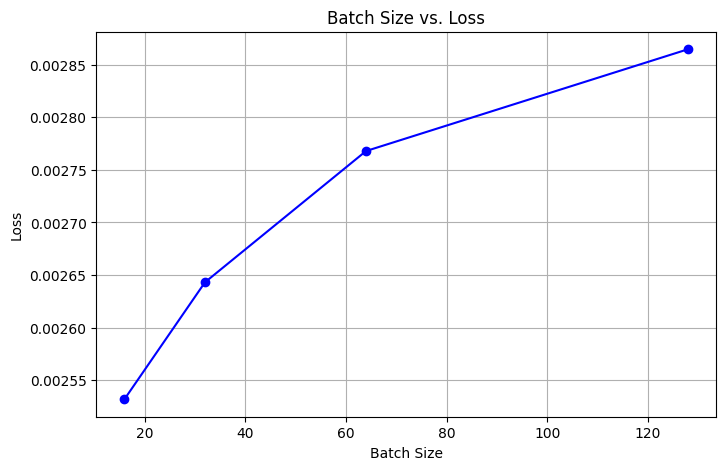

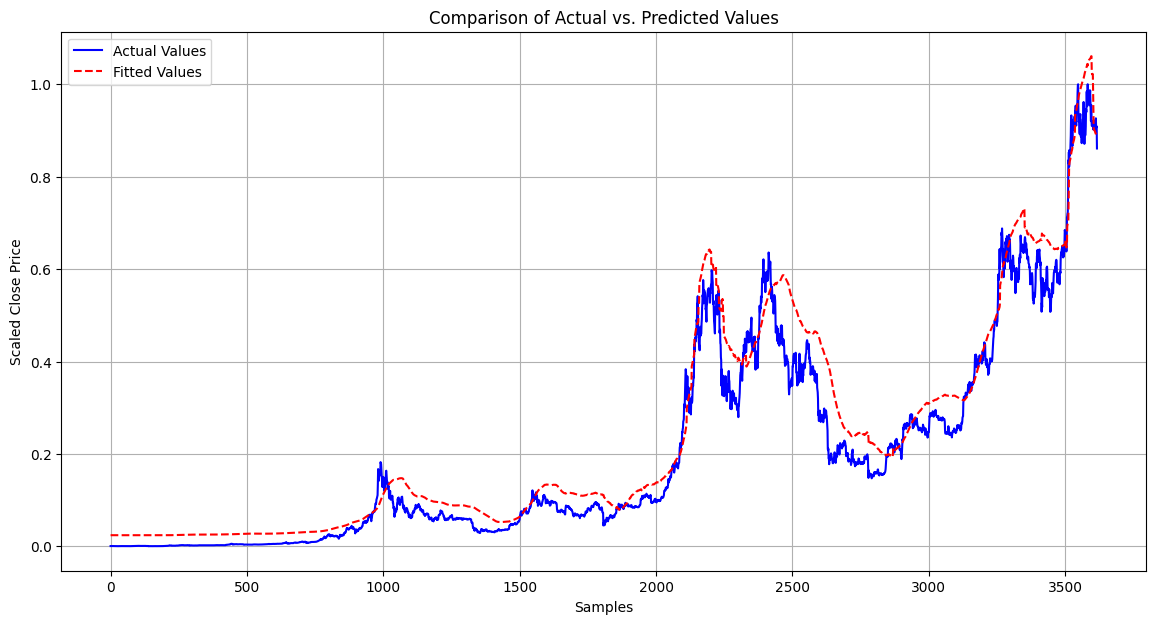


📊 **Predicted Prices for the Next 7 Days**
2025-02-25 → $78336.62
2025-02-26 → $75429.75
2025-02-27 → $77044.51
2025-02-28 → $77426.67
2025-03-01 → $73141.27
2025-03-02 → $74635.20
2025-03-03 → $75012.07

📊 **Predicted Prices for the Next 30 Days**
2025-02-25 → $72224.51
2025-02-26 → $69698.62
2025-02-27 → $72019.30
2025-02-28 → $70550.79
2025-03-01 → $71940.90
2025-03-02 → $73762.94
2025-03-03 → $73115.79
2025-03-04 → $75034.86
2025-03-05 → $75639.30
2025-03-06 → $71946.64
2025-03-07 → $68966.44
2025-03-08 → $65649.49
2025-03-09 → $69038.34
2025-03-10 → $69331.25
2025-03-11 → $73867.06
2025-03-12 → $71808.05
2025-03-13 → $71508.17
2025-03-14 → $66427.10
2025-03-15 → $74603.21
2025-03-16 → $64458.58
2025-03-17 → $71644.97
2025-03-18 → $74543.10
2025-03-19 → $67960.73
2025-03-20 → $70239.39
2025-03-21 → $71275.81
2025-03-22 → $72674.06
2025-03-23 → $70423.20
2025-03-24 → $68436.61
2025-03-25 → $68489.51
2025-03-26 → $67793.05

📊 **Predicted Prices for the Next 1 Year**
2025-02-25 → $71

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### Compute MAPE and RMSE ###
def evaluate_model(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

# Get true values and model predictions for the training set
model.eval()
y_train_pred = model(X_train).detach().cpu().numpy().flatten()
y_train_true = y_train.detach().cpu().numpy().flatten()

# Calculate MAPE and RMSE for the training set
mape_train, rmse_train = evaluate_model(y_train_true, y_train_pred)

print(f"MAPE: {mape_train:.6f}")
print(f"RMSE: {rmse_train:.6f}")

### Plot Batch Size vs. Loss ###
batch_sizes = [16, 32, 64, 128]
loss_values = []  # Store loss for different batch sizes

for batch_size in batch_sizes:
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    for batch_X, batch_y in train_loader:
        output = model(batch_X)
        loss = criterion(output, batch_y)
        total_loss += loss.item()
    loss_values.append(total_loss / len(train_loader))

plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.title("Batch Size vs. Loss")
plt.grid()
plt.show()

### Plot Actual vs. Predicted Values ###
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train_true)), y_train_true, label="Actual Values", color="blue")
plt.plot(range(len(y_train_pred)), y_train_pred, label="Fitted Values", linestyle="--", color="red")
plt.xlabel("Samples")
plt.ylabel("Scaled Close Price")
plt.title("Comparison of Actual vs. Predicted Values")
plt.legend()
plt.grid()
plt.show()

### 5️⃣ Output Predicted Values ###
print("\n📊 **Predicted Prices for the Next 7 Days**")
for date, price in zip(future_dates_7, future_7_days):
    print(f"{date.date()} → ${price:.2f}")

print("\n📊 **Predicted Prices for the Next 30 Days**")
for date, price in zip(future_dates_30, future_30_days):
    print(f"{date.date()} → ${price:.2f}")

print("\n📊 **Predicted Prices for the Next 1 Year**")
for date, price in zip(future_dates_365[:100], future_365_days[:100]):  # Print only the first 100 days
    print(f"{date.date()} → ${price:.2f}")


📥 Downloading Bitcoin data (10 years)...


[*********************100%***********************]  1 of 1 completed


✅ Data ready: Training samples = 3531
🚀 Training the model...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Loss: 0.285034
Epoch 10, Loss: 0.005069
Epoch 20, Loss: 0.003052
Epoch 30, Loss: 0.001513
Epoch 40, Loss: 0.001698
Epoch 50, Loss: 0.001196
Epoch 60, Loss: 0.001410
Epoch 70, Loss: 0.001399
Epoch 80, Loss: 0.000960
Epoch 90, Loss: 0.001038


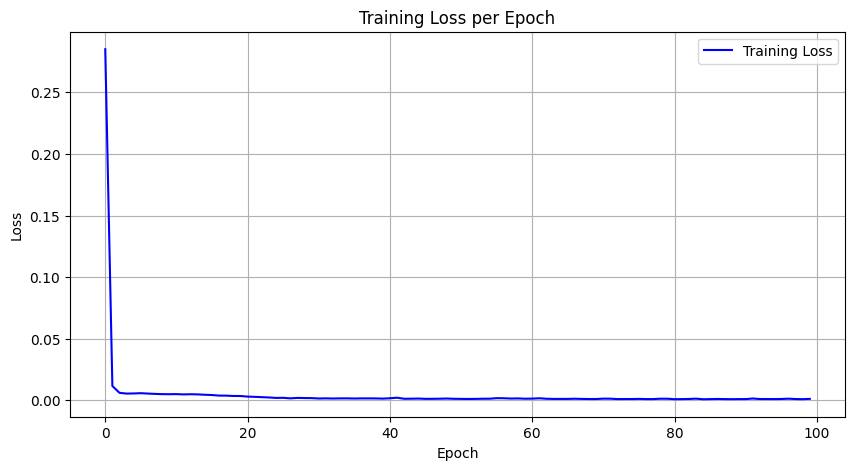

✅ Training complete!


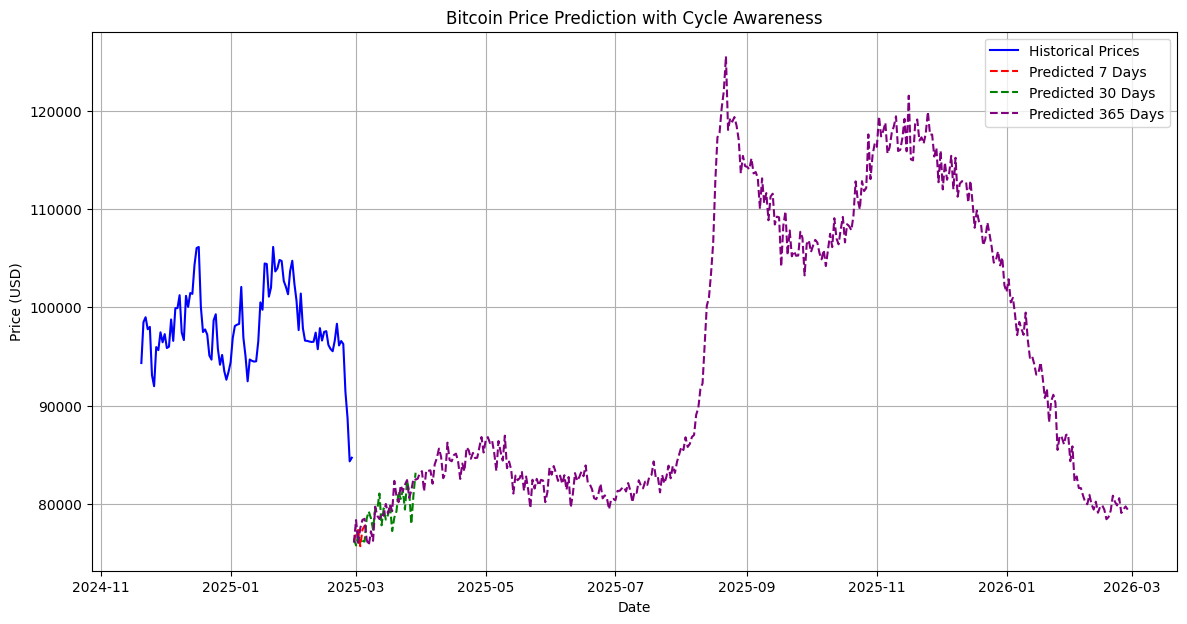

✅ Prediction complete!


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1️⃣ Fetch Bitcoin Data (10 Years) ###
print("📥 Downloading Bitcoin data (10 years)...")
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-02-28")

# Select features (Price + Volume)
btc = btc[["Close", "Volume"]]
btc.dropna(inplace=True)

# Add Halving Cycle Feature
def add_halving_cycle_feature(df):
    halving_dates = ["2012-11-28", "2016-07-09", "2020-05-11", "2024-04-20"]
    halving_dates = pd.to_datetime(halving_dates)
    df["halving_days"] = df.index.to_series().apply(lambda x: (x - halving_dates[halving_dates <= x].max()).days)
    df["sin_cycle"] = np.sin(2 * np.pi * df["halving_days"] / 1460)  # 4-year cycle
    return df

btc = add_halving_cycle_feature(btc)

# Normalize data
scalers = {}
for col in ["Close", "Volume", "sin_cycle"]:
    scalers[col] = MinMaxScaler(feature_range=(0, 1))
    btc[f"scaled_{col}"] = scalers[col].fit_transform(btc[col].values.reshape(-1, 1))

# Sliding window function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # Predicting only price
    return np.array(X), np.array(y)

seq_length = 180  # Using 180 days instead of 90
X, y = create_sequences(btc[["scaled_Close", "scaled_Volume", "scaled_sin_cycle"]].values, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

# Mini-Batch Training
batch_size = 64
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"✅ Data ready: Training samples = {X_train.shape[0]}")

### 2️⃣ Define Hybrid LSTM-Transformer Model ###
class HybridModel(nn.Module):
    def __init__(self, input_dim=3, model_dim=64, num_heads=4, num_layers=2):
        super(HybridModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, model_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.transformer(x)
        x = self.fc(x.mean(dim=1))
        return x

# Initialize model
model = HybridModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3️⃣ Train Model ###
print("🚀 Training the model...")
epochs = 100
loss_history = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_history, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

print("✅ Training complete!")

### 4️⃣ Predict Future Bitcoin Prices ###
def predict_future(days=7):
    predicted_prices = [btc["Close"].values[-1]]  # Start with last real price
    last_sequence = btc[["scaled_Close", "scaled_Volume", "scaled_sin_cycle"]].values[-seq_length:].copy()
    for _ in range(days):
        X_test = torch.tensor(last_sequence.reshape(1, seq_length, 3), dtype=torch.float32).to(device)
        predicted_scaled = model(X_test).detach().cpu().numpy()[0][0]
        predicted_real = scalers["Close"].inverse_transform([[predicted_scaled]])[0][0]
        predicted_prices.append(predicted_real)
        new_volume = last_sequence[-1, 1]
        new_sin_cycle = last_sequence[-1, 2]
        last_sequence = np.append(last_sequence[1:], [[predicted_scaled, new_volume, new_sin_cycle]], axis=0)
    return predicted_prices[1:]

future_7_days = predict_future(days=7)
future_30_days = predict_future(days=30)
future_365_days = predict_future(days=365)

future_dates_7 = pd.date_range(start=btc.index[-1], periods=8, freq='D')[1:]
future_dates_30 = pd.date_range(start=btc.index[-1], periods=31, freq='D')[1:]
future_dates_365 = pd.date_range(start=btc.index[-1], periods=366, freq='D')[1:]

df_future_7 = pd.DataFrame({"Date": future_dates_7, "Close": future_7_days}).set_index("Date")
df_future_30 = pd.DataFrame({"Date": future_dates_30, "Close": future_30_days}).set_index("Date")
df_future_365 = pd.DataFrame({"Date": future_dates_365, "Close": future_365_days}).set_index("Date")

plt.figure(figsize=(14, 7))
plt.plot(btc.index[-100:], btc["Close"].values[-100:], label="Historical Prices", color="blue")
plt.plot(df_future_7.index, df_future_7["Close"], label="Predicted 7 Days", linestyle="--", color="red")
plt.plot(df_future_30.index, df_future_30["Close"], label="Predicted 30 Days", linestyle="--", color="green")
plt.plot(df_future_365.index, df_future_365["Close"], label="Predicted 365 Days", linestyle="--", color="purple")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Prediction with Cycle Awareness")
plt.legend()
plt.grid()
plt.show()

print("✅ Prediction complete!")


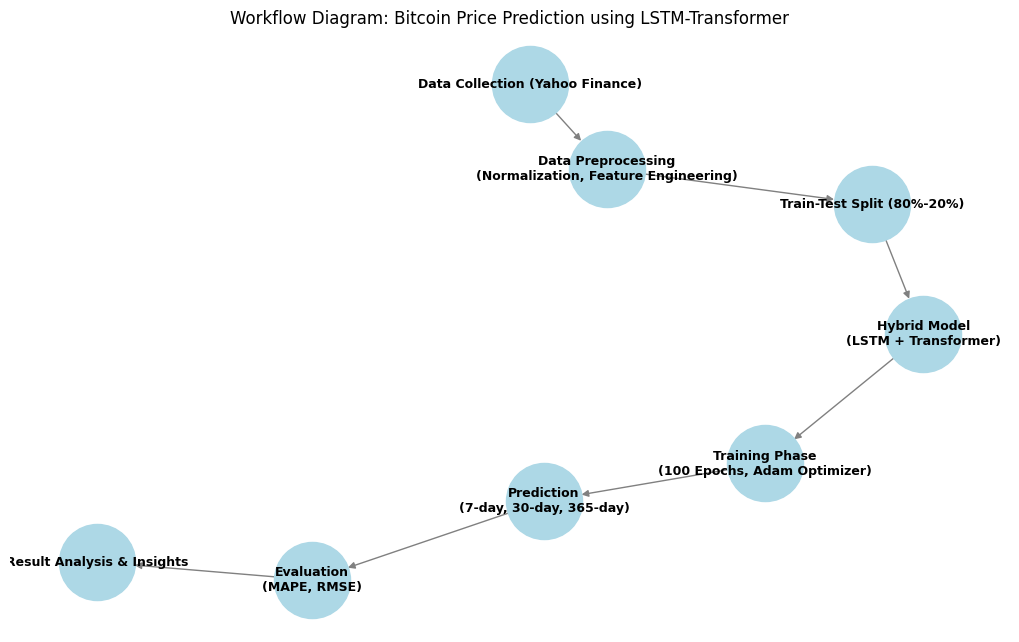

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the workflow steps
workflow_steps = [
    "Data Collection (Yahoo Finance)",
    "Data Preprocessing\n(Normalization, Feature Engineering)",
    "Train-Test Split (80%-20%)",
    "Hybrid Model\n(LSTM + Transformer)",
    "Training Phase\n(100 Epochs, Adam Optimizer)",
    "Prediction\n(7-day, 30-day, 365-day)",
    "Evaluation\n(MAPE, RMSE)",
    "Result Analysis & Insights"
]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for step in workflow_steps:
    G.add_node(step)

# Define edges (workflow sequence)
edges = [
    ("Data Collection (Yahoo Finance)", "Data Preprocessing\n(Normalization, Feature Engineering)"),
    ("Data Preprocessing\n(Normalization, Feature Engineering)", "Train-Test Split (80%-20%)"),
    ("Train-Test Split (80%-20%)", "Hybrid Model\n(LSTM + Transformer)"),
    ("Hybrid Model\n(LSTM + Transformer)", "Training Phase\n(100 Epochs, Adam Optimizer)"),
    ("Training Phase\n(100 Epochs, Adam Optimizer)", "Prediction\n(7-day, 30-day, 365-day)"),
    ("Prediction\n(7-day, 30-day, 365-day)", "Evaluation\n(MAPE, RMSE)"),
    ("Evaluation\n(MAPE, RMSE)", "Result Analysis & Insights")
]

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Positioning for better visualization
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=9, font_weight="bold", edge_color="gray", arrows=True)
plt.title("Workflow Diagram: Bitcoin Price Prediction using LSTM-Transformer")
plt.show()